In [150]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf

In [4]:
x_scaled_df = pd.read_pickle("./x_scaled_df.pkl")
y_arr = np.load("./y_arr.npy")


In [28]:
cat_columns = ['ID', 'loan_type', 'lender_id']

In [70]:
unbalance_ratio = (y_arr==1).sum() / (y_arr==0).sum() 
ratio_of_pos = (y_arr==1).sum() / (y_arr.shape[0])
number_of_val_pos = int((x_scaled_df.shape[0] / 10)*ratio_of_pos)
number_of_val_neg = int((x_scaled_df.shape[0] / 10) - number_of_val_pos)
indexes_of_pos = np.where(y_arr==1)
indexes_of_neg = np.where(y_arr==0)

In [78]:
x_neg_df = x_scaled_df.loc[indexes_of_neg]

In [81]:
x_neg_val_df = x_neg_df.sample(n=number_of_val_neg, random_state=42)

In [89]:
y_neg_val = y_arr[x_neg_val_df.index]
x_neg_val_arr = x_neg_val_df.to_numpy()


In [53]:
x_one_arr = x_scaled_df.loc[indexes_of_pos].to_numpy()

In [63]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=number_of_val_pos, random_state=42)
x_dist = km.fit_transform(X=x_one_arr[:, 3:])
most_representative_pos = np.argmin(x_dist, axis=0)
x_pos_repr_val = x_one_arr[most_representative_pos]


In [95]:
y_pos_val = np.full(shape=(x_pos_repr_val.shape[0]),fill_value=1)

In [146]:
x_val_stacked = np.vstack((x_pos_repr_val, x_neg_val_arr))  
y_val_stacked = np.hstack((y_pos_val, y_neg_val))        
indices = np.arange(x_val_stacked.shape[0])  
np.random.shuffle(indices)       
x_val_ID = x_val_stacked[indices]
x_val=x_val_ID[:,1:]
y_val = y_val_stacked[indices]

In [139]:
indexes_to_exclude = set(x_neg_val_df.index).union(x_scaled_df.loc[indexes_of_pos].iloc[most_representative_pos].index)  # Combine both index sets
x_train_df = x_scaled_df.drop(index=indexes_to_exclude)
x_train = x_train_df.drop(['ID'], axis=1).to_numpy()
y_train = y_arr[x_train_df.index]

In [238]:
x_train_num = x_train[:,2:]
x_train_num = np.array(x_train_num, dtype=np.float32)
x_val_num = x_val[:,2:]
x_val_num = np.array(x_val_num, dtype=np.float32)

x_train_loan = x_train[:,0]
x_val_loan = x_val[:,0]

x_train_lender = x_train[:,1]
x_val_lender = x_val[:,1]

In [220]:
loan_types_unique_list = list(x_scaled_df['loan_type'].unique())
lenders_unique_list = list(x_scaled_df['lender_id'].unique())

In [221]:
def embedding_output_dim(input_dim):
    return round((1.6*input_dim)**0.56)

In [222]:
tf.random.set_seed(42)
loan_type_look_up_layer = tf.keras.layers.StringLookup()
loan_type_look_up_layer.adapt(loan_types_unique_list)
lookup_and_embed_loan_type = tf.keras.Sequential([
    loan_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=loan_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(loan_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])


In [223]:
lender_type_look_up_layer = tf.keras.layers.StringLookup()
lender_type_look_up_layer.adapt(lenders_unique_list)
lookup_and_embed_lender_type = tf.keras.Sequential([
    lender_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=lender_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(lender_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])

In [224]:
num_input = tf.keras.layers.Input(shape=[15], name="num")
loan_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="loan_cat")
lender_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="lender_cat")

loan_embeddings = lookup_and_embed_loan_type(loan_cat_input)
lender_embeddings = lookup_and_embed_lender_type(lender_cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, loan_embeddings, lender_embeddings])

number_of_neurons_per_layer = 100
number_of_layers_deep = 10
number_of_layers_wide = 2
activation = tf.keras.activations.silu 
kernel_innit = "he_normal"



deep_path = encoded_inputs
for i in range(number_of_layers_deep): 
    deep_path = tf.keras.layers.BatchNormalization()(deep_path)
    deep_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=tf.keras.activations.silu, kernel_initializer=kernel_innit)(deep_path)

# Wide path
wide_path = encoded_inputs
for i in range(number_of_layers_wide):  # number_of_layers_wide
    wide_path = tf.keras.layers.BatchNormalization()(wide_path)
    wide_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=tf.keras.activations.silu, kernel_initializer=kernel_innit)(wide_path)

# Combine deep and wide paths
concat_layer = tf.keras.layers.concatenate([deep_path, wide_path])

# Output layer
output = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=kernel_innit)(concat_layer)

# Define the model
model_ = tf.keras.Model(inputs=[num_input, loan_cat_input, lender_cat_input], outputs=output)


In [225]:
learning_rate = 0.001
Optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
Loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.98)
Metrics =  [tf.keras.metrics.AUC(name='pr_auc', curve='PR'), tf.keras.metrics.Precision(),]
Batch_Size = 32
Epochs = 50

In [226]:
model_.compile(
    optimizer=Optimizer,  
    loss=Loss,
    metrics=Metrics,
)

In [239]:
history = model_.fit(
    (x_train_num, x_train_loan, x_train_lender),
    y_train,
    callbacks=[lr_scheduler, early_stop],
    batch_size=Batch_Size,
    epochs=Epochs,
    validation_data=((x_val_num, x_val_loan, x_val_lender), y_val)
)

Epoch 1/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - loss: 0.0080 - pr_auc: 0.7774 - precision_1: 0.8026 - val_loss: 0.0095 - val_pr_auc: 0.7533 - val_precision_1: 0.8814 - learning_rate: 0.0010
Epoch 2/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 0.0073 - pr_auc: 0.8063 - precision_1: 0.8260 - val_loss: 0.0095 - val_pr_auc: 0.7777 - val_precision_1: 0.8769 - learning_rate: 0.0010
Epoch 3/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - loss: 0.0068 - pr_auc: 0.8254 - precision_1: 0.8278 - val_loss: 0.0102 - val_pr_auc: 0.7905 - val_precision_1: 0.8551 - learning_rate: 0.0010
Epoch 4/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 0.0065 - pr_auc: 0.8382 - precision_1: 0.8363 - val_loss: 0.0123 - val_pr_auc: 0.7919 - val_precision_1: 0.8939 - learning_rate: 0.0010
Epoch 5/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 0.0063 - pr_auc: 0.8462 - precision_1: 0.8419 - val_loss: 0.0156 - val_pr_auc: 0.7735 - val_precision_1: 0.8507 - learning_rate: 0.0010


In [245]:
import matplotlib.pyplot as plt

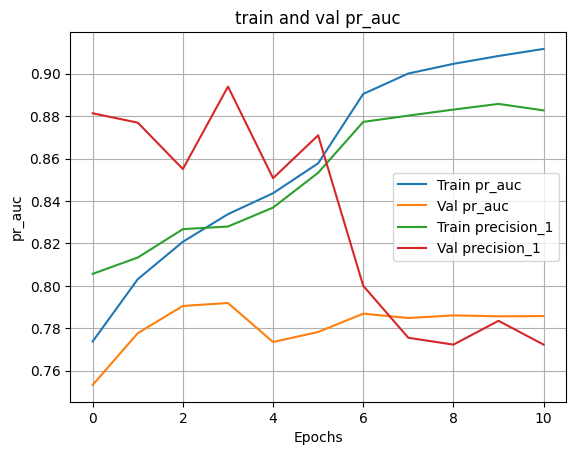

In [247]:
train_pr_auc = history.history['pr_auc']  
val_pr_auc = history.history['val_pr_auc']  

train_precision_1 = history.history['precision_1']  
val_precision_1 = history.history['val_precision_1']  


plt.plot(train_pr_auc, label='Train pr_auc')
plt.plot(val_pr_auc, label='Val pr_auc')
plt.plot(train_precision_1, label='Train precision_1')
plt.plot(val_precision_1, label='Val precision_1')
plt.xlabel('Epochs')
plt.ylabel('pr_auc - precision')
plt.title('train and val pr_auc-precision')
plt.legend()
plt.grid(True)
plt.show()